In [1]:
import tensorflow as tf
import transformers
import keras
from keras.models import Model

In [2]:
from tensorflow.data import Dataset
from tensorflow import keras
from collections import Counter
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, smart_resize
from PIL import ImageFile

In [3]:
import torch
import numpy as np
import tensorflow as tf
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
VIDEO_PATH = "/kaggle/input/unber-1111/UNBER-1k/Extracted_Frames"  # Path for video frames
AUDIO_PATH = "/kaggle/input/unber-1111/UNBER-1k/Audios"  # Path for audio files
TEXT_CSV = "/kaggle/input/unber-1111/UNBER-1k/text.csv"

In [5]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [6]:
tdf['Visual texts'] = tdf['Visual texts'].fillna("কোন টেক্সট পাওয়া যায়নি")

In [7]:
tdf.head()

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie
1,www.facebook.com/reel/1006146964533997,Safe,কোন টেক্সট পাওয়া যায়নি
2,www.facebook.com/reel/1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love
3,www.facebook.com/reel/1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop
4,www.facebook.com/reel/1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং


In [8]:
tdf['UnsafeType'].value_counts()

UnsafeType
Safe        441
Adult       327
Harmful     221
Suicidal    122
Name: count, dtype: int64

In [9]:
tdf['UnsafeType'], uniques = pd.factorize(tdf['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [10]:
pip install noisereduce

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [12]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [13]:
def load_video_frames(folder_path):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [14]:
def process_audio_file(file_path, target_length=5, sample_rate=22050, n_mfcc=13, n_chroma=12, n_spectral_contrast=6, target_length_features=20):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Trim or pad audio to target length
    target_samples = target_length * sr
    if len(audio) > target_samples:
        audio = audio[:target_samples]  # Trim
    else:
        padding = target_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')  # Pad with silence

    # Normalize audio (zero mean, unit variance)
    mean = np.mean(audio)
    std = np.std(audio)
    safe_std = max(std, 1e-8)  # Avoid division by zero
    audio = (audio - mean) / safe_std

    # Apply noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    if not np.isfinite(reduced_noise_audio).all():
        print("Warning: Noise reduction produced NaN/Inf values, reverting to original audio.")
        reduced_noise_audio = audio  # Use original if noise reduction fails
    
    reduced_noise_audio = np.nan_to_num(reduced_noise_audio)

    # Feature Extraction
    def truncate_or_pad(feature, target_length_features):
        """Ensures features have a fixed length by truncating or padding."""
        if feature.shape[1] > target_length_features:
            return feature[:, :target_length_features]
        else:
            return np.pad(feature, ((0, 0), (0, target_length_features - feature.shape[1])), mode='constant')

    # Extract MFCCs (13 coefficients)
    mfcc = librosa.feature.mfcc(y=reduced_noise_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = truncate_or_pad(mfcc, target_length_features)

    # Extract Chroma Features (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=reduced_noise_audio, sr=sr, n_chroma=n_chroma)
    chroma = truncate_or_pad(chroma, target_length_features)

    # Extract Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=reduced_noise_audio, sr=sr)
    spectral_centroid = truncate_or_pad(spectral_centroid, target_length_features)

    # Extract Spectral Contrast (6 bands)
    spectral_contrast = librosa.feature.spectral_contrast(y=reduced_noise_audio, sr=sr, n_bands=n_spectral_contrast)
    spectral_contrast = truncate_or_pad(spectral_contrast, target_length_features)

    # Extract Spectrogram (Magnitude Spectrogram)
    spectrogram = np.abs(librosa.stft(reduced_noise_audio))
    spectrogram = truncate_or_pad(spectrogram, target_length_features)

    # Flatten all features into a single vector
    feature_vector = np.concatenate([
        mfcc.flatten(),
        chroma.flatten(),
        spectral_centroid.flatten(),
        spectral_contrast.flatten(),
        spectrogram.flatten()
    ])

    return feature_vector

In [15]:
X_video, X_audio, X_text, y = [], [], [], []

In [16]:
for _, row in tdf.iterrows():
    reel_id = row["reel_id"].split("/")[-1]  
    label = row["UnsafeType"]  

    video_folder = os.path.join(VIDEO_PATH, reel_id)
    audio_file = os.path.join(AUDIO_PATH, f"audio{reel_id}.wav")

    if os.path.isdir(video_folder) and os.path.exists(audio_file):
        frames = load_video_frames(video_folder)  
        processed_audio = process_audio_file(audio_file)  
        text_feature = row["Visual texts"]  

        X_video.append(frames)
        X_audio.append(processed_audio)
        X_text.append(text_feature)
        y.append(label)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: divide by zero encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [17]:
print(len(X_video), len(X_audio), len(X_text), len(y))

1111 1111 1111 1111


In [18]:
X_video = np.array(X_video) 
X_audio = np.array(X_audio, dtype=np.float32)
X_text = np.array(X_text)  
y = np.array(y)

In [19]:
X_video.shape

(1111, 5, 224, 224, 3)

In [20]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler()

# # Scale X_video, X_audio, and X_text
# X_video_scaled = scaler.fit_transform(X_video.reshape(X_video.shape[0], -1))  # Flatten video frames
# X_audio_scaled = scaler.fit_transform(X_audio.reshape(X_audio.shape[0], -1))  # Flatten audio features

In [21]:
# X_video = X_video.reshape(-1, 224, 224, 3)
# X_audio = np.repeat(X_audio, 5, axis=0)
# X_text = np.repeat(X_text, 5, axis=0)
# y = np.repeat(y, 5, axis=0)

In [22]:
X_video.shape

(1111, 5, 224, 224, 3)

In [23]:
X_audio.shape 

(1111, 21160)

In [24]:
X_audio = np.expand_dims(X_audio, axis=-1)

In [25]:
X_audio.shape

(1111, 21160, 1)

In [26]:
X_text.shape

(1111,)

In [27]:
y.shape 

(1111,)

In [28]:
# Step 1: Split into train and temp (val + test)
X_train_vid, X_temp_vid, X_train_aud, X_temp_aud, X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X_video, X_audio, X_text, y, test_size=0.2, random_state=42, shuffle=True
)

# Step 2: Split temp into val and test
X_val_vid, X_test_vid, X_val_aud, X_test_aud, X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_vid, X_temp_aud, X_temp_text, y_temp, test_size=0.5, random_state=42, shuffle=True
)

## Text Preprocessing

In [29]:
model_name = "csebuetnlp/banglabert"

In [30]:
from transformers import AutoModelForPreTraining, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
train_encodings = tokenizer(list(X_train_text), max_length=512, truncation=True, padding="max_length", return_tensors='tf')
print(np.shape(train_encodings["input_ids"]))

val_encodings = tokenizer(list(X_val_text), max_length=512, truncation=True, padding="max_length", return_tensors='tf')
print(np.shape(val_encodings["input_ids"]))

test_encodings = tokenizer(list(X_test_text), max_length=512, truncation=True, padding="max_length", return_tensors='tf')
print(np.shape(test_encodings["input_ids"]))

(888, 512)
(111, 512)
(112, 512)


## Audio Preprocessing

In [32]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define Autoencoder (512-D encoded representation)
def build_audio_autoencoder(input_dim=21160, latent_dim=512):
    input_audio = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(256, activation='relu')(input_audio)
    encoded = Dense(latent_dim, activation='relu')(encoded)  # Compressed 512-D representation

    # Decoder
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Reconstruct original input

    autoencoder = Model(input_audio, decoded)
    encoder = Model(input_audio, encoded)  # This will be used for fusion

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Create the autoencoder
autoencoder, audio_encoder = build_audio_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,417,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21160)               │       5,438,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,118,248 (42.41 MB)

 Trainable params: 11,118,248 (42.41 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Train the Autoencoder
autoencoder.fit(
    X_train_aud, X_train_aud,
    epochs=100, batch_size=16, shuffle=True,
    validation_data=(X_val_aud, X_val_aud),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8727.6387 - val_loss: 9402.3838 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9506.1729 - val_loss: 9402.3867 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9330.8945 - val_loss: 9402.4180 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8871.1406 - val_loss: 9402.4932 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9662.6709 - val_loss: 9402.5264 - learning_rate: 0.0010
Epoch 6/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9036.3447
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9045.8906 - val_loss: 9402.5537 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9304.3828 - val_loss: 9402.5615 - learning_rate: 5.0000e-04
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

## Image Processing

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel, ViTFeatureExtractor

In [35]:
class ViT_LSTM_Model(nn.Module):
    def __init__(self, vit_model, lstm_hidden_size=256, num_classes=4):
        super(ViT_LSTM_Model, self).__init__()
        self.vit = vit_model
        self.lstm_hidden_size = lstm_hidden_size
        self.num_classes = num_classes

        # Freeze ViT parameters (only train LSTM and classifier)
        for param in self.vit.parameters():
            param.requires_grad = False

        # LSTM to process ViT feature sequences
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)

        # Fully connected classifier
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)

        with torch.no_grad():  # Extract features using ViT
            features = self.vit(x).last_hidden_state[:, 0, :]

        features = features.view(batch_size, num_frames, -1)  # Reshape back to (batch, num_frames, 768)
        lstm_out, _ = self.lstm(features)  # LSTM processing
        final_output = lstm_out[:, -1, :]  # Take the last LSTM output

        return final_output

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
vit_lstm_model = ViT_LSTM_Model(vit_model).to(device)
vit_lstm_model.load_state_dict(torch.load("/kaggle/input/unber-1k/vit_lstm_model.pth", map_location=device))
vit_lstm_model.eval()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-36-c727fe798d63>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

ViT_LSTM_Model(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768,

In [37]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [38]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # Shape: (num_frames, 224, 224, 3)
        label = self.y[idx]

        # Convert to tensor and normalize
        video = torch.tensor(video, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (num_frames, 3, 224, 224)
        return video, torch.tensor(label, dtype=torch.long)

In [39]:
train_dataset = VideoDataset(X_train_vid, y_train)
val_dataset = VideoDataset(X_val_vid, y_val)
test_dataset = VideoDataset(X_test_vid, y_test)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [41]:
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = vit_lstm_model(videos)
        print(outputs.shape)

torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])


In [42]:
import torch

def extract_visual_features(model, data_loader, device):
    all_features = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for videos, _ in data_loader:  # Only extracting features, so labels are ignored
            videos = videos.to(device)
            features = model(videos)  # Shape: (batch_size, 256) from ViT-LSTM
            all_features.append(features.cpu())  # Move to CPU and store

    return torch.cat(all_features, dim=0)  # Stack all feature tensors

In [43]:
X_train_vid_f = extract_visual_features(vit_lstm_model, train_loader, device)

print("Extracted Visual Features Shape:", X_train_vid_f.shape)  # (num_samples, 256)

Extracted Visual Features Shape: torch.Size([888, 256])


In [44]:
X_train_vid_f = extract_visual_features(vit_lstm_model, train_loader, device)
X_test_vid_f = extract_visual_features(vit_lstm_model, test_loader, device)
X_val_vid_f = extract_visual_features(vit_lstm_model, val_loader, device)

In [45]:
print(X_train_vid_f.shape)
print(X_test_vid_f.shape)
print(X_val_vid_f.shape)

torch.Size([888, 256])
torch.Size([112, 256])
torch.Size([111, 256])


In [46]:
X_train_aud_f = audio_encoder.predict(X_train_aud)  
X_val_aud_f = audio_encoder.predict(X_val_aud)
X_test_aud_f = audio_encoder.predict(X_test_aud)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [47]:
print(X_train_aud_f.shape)
print(X_test_aud_f.shape)
print(X_val_aud_f.shape)

(888, 512)
(112, 512)
(111, 512)


In [48]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoModel

In [49]:
model_name = "/kaggle/input/unber-1k/ReelBBert-20250215T144010Z-001/ReelBBert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
banglabert_model = AutoModel.from_pretrained(model_name)

In [50]:
def get_text_embedding(texts):
    """Extracts [CLS] embeddings for a list of texts using BanglaBERT."""
    banglabert_model.eval()  # Set model to evaluation mode
    embeddings = []

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
            outputs = banglabert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Extract [CLS] token
            embeddings.append(cls_embedding)

    return np.array(embeddings) 

In [51]:
train_emb = get_text_embedding(X_train_text) 

In [52]:
train_emb.shape

(888, 768)

In [53]:
test_emb = get_text_embedding(X_test_text)
val_emb = get_text_embedding(X_val_text)

In [54]:
X_train_text_f = train_emb
X_test_text_f = test_emb
X_val_text_f = val_emb

In [55]:
print(X_train_text_f.shape)
print(X_test_text_f.shape)
print(X_val_text_f.shape)

(888, 768)
(112, 768)
(111, 768)


In [56]:
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout, GlobalAveragePooling1D

In [57]:
from tensorflow.keras.layers import Attention

In [70]:
from tensorflow.keras.layers import Dense, Reshape

def cross_modal_attention_block(query, key, value, proj_dim=256):
    # Project all inputs to the same dimension
    query_proj = Dense(proj_dim)(query)
    key_proj = Dense(proj_dim)(key)
    value_proj = Dense(proj_dim)(value)

    # Reshape for attention
    query_proj = Reshape((1, proj_dim))(query_proj)
    key_proj = Reshape((1, proj_dim))(key_proj)
    value_proj = Reshape((1, proj_dim))(value_proj)

    # Apply attention
    attention_layer = Attention()([query_proj, key_proj, value_proj])
    attention_layer = Reshape((proj_dim,))(attention_layer)  # Flatten back

    return Concatenate()([query, attention_layer])  # Use original query + attended features


In [87]:
from tensorflow.keras.layers import Dense, Add, Multiply, Activation

def gated_fusion(img_feat, aud_feat, text_feat, proj_dim=512):
    # Project all features to the same dimension
    img_proj = Dense(proj_dim)(img_feat)
    aud_proj = Dense(proj_dim)(aud_feat)
    text_proj = Dense(proj_dim)(text_feat)

    # Compute gating values using a sigmoid activation
    img_gate = Activation('sigmoid')(Dense(1)(img_proj))
    aud_gate = Activation('sigmoid')(Dense(1)(aud_proj))
    text_gate = Activation('sigmoid')(Dense(1)(text_proj))

    # Multiply gates with respective features
    gated_img = Multiply()([img_gate, img_proj])
    gated_aud = Multiply()([aud_gate, aud_proj])
    gated_text = Multiply()([text_gate, text_proj])

    # Sum the gated features for final fusion
    fused_output = Add()([gated_img, gated_aud, gated_text])

    return fused_output

In [88]:
def attention_based_fusion():
    # Image Input (2048-D from ResNet)
    img_input = Input(shape=(256,), name="image_input")

    # Audio Input (256-D from Autoencoder)
    audio_input = Input(shape=(512,), name="audio_input")

    # Precomputed Text Embeddings (768-D from BanglaBERT)
    text_input = Input(shape=(768,), name="text_input")  

    img_text_att = cross_modal_attention_block(img_input, text_input, text_input)
    audio_text_att = cross_modal_attention_block(audio_input, text_input, text_input)
    
    # Cross-modal attention (text -> image, text -> audio)
    text_img_att = cross_modal_attention_block(text_input, img_input, img_input)
    text_audio_att = cross_modal_attention_block(text_input, audio_input, audio_input)
    
    # Concatenate enhanced features
    fused_features = gated_fusion(img_text_att, audio_text_att, text_img_att, proj_dim=512)

    # Fully Connected Layers
    X = BatchNormalization()(fused_features)
    X = Dense(128, activation='tanh')(X)
    X = Dropout(0.3)(X)
    X = Dense(64, activation='tanh')(X)
    X = Dense(4, activation='softmax', name="output")(X)  # Properly connected output layer

    # Define Model
    model = Model(inputs=[img_input, audio_input, text_input], outputs=X)  
    
    return model

In [89]:
model = attention_based_fusion()

In [90]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_input (InputLayer)  │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 256)            │         65,792 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 256)            │        196,864 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_54 (Dense)          │ (None, 256)            │        196,864 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_55 (Dense)          │ (None, 256)            │        131,328 │ audio_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_56 (Dense)          │ (None, 256)            │        196,864 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_57 (Dense)          │ (None, 256)            │        196,864 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_58 (Dense)          │ (None, 256)            │        196,864 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_59 (Dense)          │ (None, 256)            │         65,792 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 256)            │         65,792 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_64 (Reshape)      │ (None, 1, 256)         │              0 │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_65 (Reshape)      │ (None, 1, 256)         │              0 │ dense_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_66 (Reshape)      │ (None, 1, 256)         │              0 │ dense_54[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_68 (Reshape)      │ (None, 1, 256)         │              0 │ dense_55[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_69 (Reshape)      │ (None, 1, 256)         │              0 │ dense_56[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_70 (Reshape)      │ (None, 1, 256)         │              0 │ dense_57[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_72 (Reshape)      │ (None, 1, 256)         │              0 │ dense_58[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_73 (Reshape) 

 Total params: 2,571,975 (9.81 MB)

 Trainable params: 2,570,951 (9.81 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [91]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [92]:
history = model.fit(
    x=[X_train_vid_f, X_train_aud_f, X_train_text_f],  # Training inputs
    y=y_train,                                 # Training labels
    batch_size=32,
    epochs=30,
    validation_data=([X_val_vid_f, X_val_aud_f, X_val_text_f], y_val),  # Validation inputs and labels
    shuffle=True
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy: 0.3302 - loss: 1.4549 - val_accuracy: 0.5856 - val_loss: 1.0854
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6894 - loss: 0.8481 - val_accuracy: 0.7477 - val_loss: 0.7321
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7278 - loss: 0.7616 - val_accuracy: 0.6306 - val_loss: 0.8905
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7565 - loss: 0.6554 - val_accuracy: 0.6937 - val_loss: 0.8616
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7499 - loss: 0.6598 - val_accuracy: 0.6396 - val_loss: 0.8567
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7555 - loss: 0.6517 - val_accuracy: 0.7568 - val_loss: 0.6964
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7291 - loss: 0.6593 - val_accuracy: 0.7117 - val_loss: 0.8671
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7655 - loss: 0.6049 - val_accuracy: 0.7297 - val_loss: 0.7212


In [94]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the validation data
y_pred = model.predict(
    [X_test_vid_f, X_test_aud_f, X_test_text_f],  # Validation inputs
    batch_size=32
)

y_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[5.62823936e-03, 3.12528049e-04, 9.93956447e-01, 1.02786857e-04],
       [5.21480255e-02, 1.36405295e-02, 9.33571100e-01, 6.40318205e-04],
       [1.87966116e-02, 1.19538531e-02, 9.67940390e-01, 1.30909821e-03],
       [9.23432231e-01, 2.93340422e-02, 4.39904965e-02, 3.24318907e-03],
       [9.30052876e-01, 4.07406278e-02, 2.84129642e-02, 7.93560641e-04],
       [2.31540620e-01, 7.04197168e-01, 6.17287233e-02, 2.53353361e-03],
       [1.96449265e-01, 3.52610826e-01, 4.42430139e-01, 8.50977935e-03],
       [1.74675081e-02, 5.12240306e-02, 9.30072963e-01, 1.23548985e-03],
       [9.96992707e-01, 1.44467165e-03, 1.11264677e-03, 4.49897547e-04],
       [1.68713811e-03, 1.72727611e-02, 6.57070952e-04, 9.80383039e-01],
       [5.01721241e-02, 9.35421228e-01, 1.15534328e-02, 2.85322429e-03],
       [9.54262674e-01, 2.07899953e-03, 4.26566750e-02, 1.00160565e-03],
       [3.06740731e-01, 1.21778324e-01, 5.64449131e-01, 7.03176111e-03],
       [3.30681540e-03, 3.44189320e-04, 9.96289849e

In [95]:
# If the model's output is probabilities, get the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

array([2, 2, 2, 0, 0, 1, 2, 2, 0, 3, 1, 0, 2, 2, 0, 0, 1, 1, 0, 3, 0, 2,
       1, 0, 1, 0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 1, 3, 0, 2, 0, 0,
       0, 3, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 3, 3, 0, 1, 1, 1, 1,
       0, 0, 2, 2, 0, 1, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 1,
       0, 3, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 1, 0, 3, 0,
       0, 1])

In [96]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.82      0.68        39
           1       0.70      0.42      0.52        38
           2       0.73      0.70      0.71        23
           3       1.00      1.00      1.00        12

    accuracy                           0.68       112
   macro avg       0.75      0.73      0.73       112
weighted avg       0.70      0.68      0.67       112



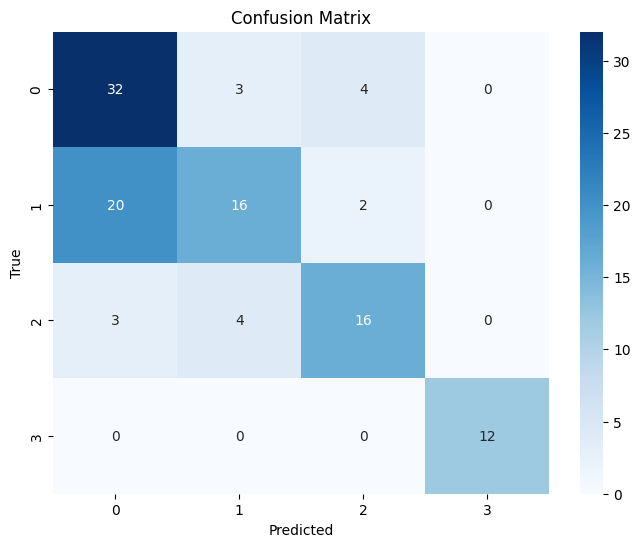

In [97]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()